# 5.2 Partial Credit Model


The **Partial Credit Model** (PCM; Masters, 1982) extends the Rating Scale Model by allowing each item to have its own set of item-category parameters. Unlike the RSM, items in the PCM are not required to share the same number of response categories, making the model especially suitable for **partial credit scoring**. This flexibility accommodates items that reflect varying degrees of correctness, such as:  
*0 = totally wrong, 1 = partially correct, 2 = almost correct, 3 = fully correct.*

The key distinction between PCM and RSM is that, in the PCM, each item-category threshold receives a unique parameter $β_{ih}$. As with the RSM, the PCM is a member of the Rasch model family and relies on the same fundamental assumptions: **unidimensionality**, **local independence**, and **equal discrimination**. The PCM can be estimated using the `eRm` package in R, and model fit can be assessed with the same tools applied previously (e.g., `itemfit()`).

## The Dataset

To demonstrate the PCM in practice, we use data from Koller et al. (2017), who examined the **Adult Self-Transcendence Inventory** (ASTI; Levenson et al., 2005). The ASTI is a self-report measure designed to assess various dimensions of **wisdom**, and includes five subscales:  

- Self-knowledge and integration (SI)  
- Peace of mind (PM)  
- Non-attachment (NA)  
- Self-transcendence (ST)  
- Presence in the here-and-now and growth (PG)

For this example, we will analyze the **PG** subscale using the PCM. This subscale consists of six items: four measured on a 3-point scale and two on a 4-point scale—an ideal scenario to demonstrate the PCM's ability to handle items with differing category structures.


## Load and inspect the dataset

In [4]:
# Imports
import numpy as np
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr

# Miscellaneous
pandas2ri.activate()
numpy2ri.activate()
ro.r('set.seed(123)')
%load_ext rpy2.ipython

# R imports
importr('mirt')      # Quick fix if future (mirt dependency) is not installed automatically: ro.r('install.packages("future", repos="https://cloud.r-project.org")')
importr('base')
importr('MPsychoR')
importr('Gifi')
importr('psych')
importr('stats')
importr('eRm')
importr('ltm')

print("\n\n" + "Python & R packages imported successfully.")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Python & R packages imported successfully.


In [6]:
# Load the data in R
ro.r("data(ASTI)")

# Convert data to a Pandas df
ASTI = pandas2ri.rpy2py(ro.globalenv['ASTI'])

# Extract PG items
PGitems = ASTI.iloc[:, [10, 13, 14, 16, 17, 22]]

# Inspect the dataset
print(PGitems.head())

# Put data back into R
ro.globalenv['PGitems'] = PGitems


   ASTI11  ASTI14  ASTI15  ASTI17  ASTI18  ASTI23
1     2.0     2.0     1.0     0.0     1.0     2.0
2     2.0     3.0     2.0     2.0     2.0     1.0
3     1.0     2.0     1.0     2.0     2.0     2.0
4     1.0     1.0     2.0     0.0     3.0     2.0
5     0.0     0.0     1.0     1.0     2.0     2.0


## Fit the model

In [7]:
ro.r('fitpcm <- PCM(PGitems)')

thresh = ro.r("thresholds(fitpcm)")
print(thresh)


Design Matrix Block 1:
       Location Threshold 1 Threshold 2 Threshold 3
ASTI11 -0.25342    -0.95748     0.45065          NA
ASTI14  0.55114    -0.36856     0.14314     1.87882
ASTI15 -0.23452    -1.10152     0.63248          NA
ASTI17  0.36189    -0.03309     0.75686          NA
ASTI18  0.60182    -0.60759     0.53785     1.87519
ASTI23  0.26095    -0.36529     0.88720          NA




The four items with three response categories get two threshold parameters only.
Goodness-of-fit evaluation is not shown here but can be performed in the same
manner as for the RSM.

## Person-item map and ICCs

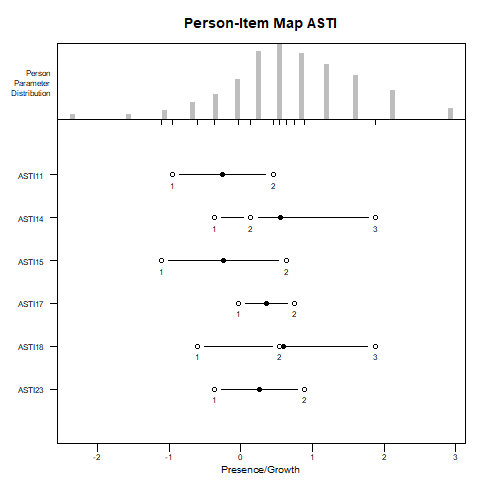

In [8]:
%%R
plotPImap(fitpcm, latdim = "Presence/Growth", main = "Person-Item Map ASTI")

In contrast to the RSM, the **PCM** allows the **distances between category thresholds to vary across items**. This flexibility captures item-specific response structures more accurately, but it also introduces potential interpretive challenges.

Occasionally, the **thresholds may appear to be “out of order”** in the PI-map. For example, threshold 2 may appear **lower** than threshold 1. This does **not** indicate a model error, but rather that the response category associated with that threshold (e.g., category 2) is never the most probable category for any level of the latent trait.

To verify such cases, it is helpful to consult the **ICCs**. These plots show the probability of endorsing each response category across the trait continuum. If threshold 2 lies below threshold 1, and category 2’s curve is never the highest at any point on the latent trait, it confirms the interpretability issue.

Although no such irregularities appear in the current model, it is still useful to explore the ICCs using the command:


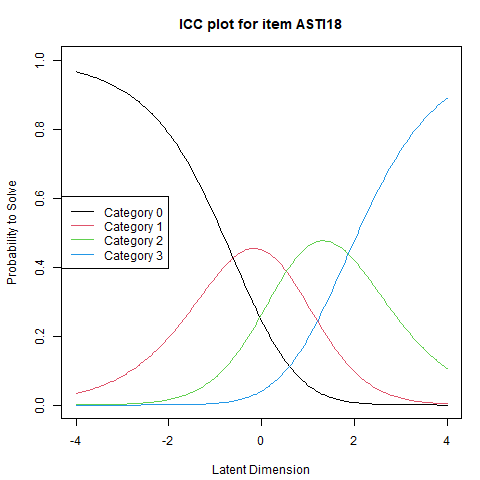

In [9]:
%%R
plotICC(fitpcm, item.subset = 5) # use item.subset = "all" to plot all items

### Test your understanding

In [17]:
from jupyterquiz import display_quiz
display_quiz("quiz/quiz_pcm.json")

<IPython.core.display.Javascript object>

# 5.3 Generalized Partial Credit Model

The **Generalized Partial Credit Model (GPCM)**, introduced by Muraki (1992), extends the Partial Credit Model by incorporating **item-specific discrimination parameters** ($\\alpha_i$). Similar to the **2-Parameter Logistic (2PL)** model in binary IRT, these $\\alpha_i$ parameters allow each item to vary in its **discrimination power**, resulting in **ICCs with different slopes**. This marks a key difference from the PCM, where discrimination is assumed to be equal across all items.

While the PCM is part of the Rasch model family—due to its fixed discrimination structure—the GPCM is **not** considered a Rasch model because it allows for **free discrimination estimation**. However, the PCM can be seen as a **special case** of the GPCM. In R, both models can be estimated using the `ltm` package via the `gpcm()` function. By setting `constraint = "rasch"` in this function, the model fixes all discrimination parameters to 1, effectively fitting a PCM.

## The Dataset

To illustrate the application of both PCM and GPCM, we return to the ASTI dataset. This time, we analyze the **self-transcendence (ST)** subscale, which consists of **seven polytomous items**. These data provide an ideal setting to examine whether allowing item discrimination to vary significantly improves model fit.


## Load and inspect the dataset

In [21]:
# Load the data in R
ro.r("data(ASTI)")

# Convert data to a Pandas df
ASTI = pandas2ri.rpy2py(ro.globalenv['ASTI'])

# Extract ST items
STitems = ASTI.iloc[:, [1,3,7,12,15,23,24]]

# Inspect the dataset
print(STitems.head())

# Put data back into R
ro.globalenv['STitems'] = STitems

   ASTI2  ASTI4  ASTI8  ASTI13  ASTI16  ASTI24  ASTI25
1    2.0    3.0    1.0     2.0     3.0     0.0     2.0
2    2.0    2.0    1.0     2.0     2.0     1.0     1.0
3    1.0    1.0    2.0     2.0     1.0     1.0     2.0
4    2.0    3.0    2.0     2.0     3.0     0.0     1.0
5    3.0    3.0    1.0     2.0     3.0     1.0     0.0


## Fit the model

In [24]:
ro.r('stpcm <- gpcm(STitems, constraint = "rasch")') # Partial Credit Model
ro.r('stgpcm <- gpcm(STitems)')                      # Generalized Partial Credit Model

print(ro.r('summary(stpcm)'))
print(ro.r('summary(stgpcm)'))


Call:
gpcm(data = STitems, constraint = "rasch")

Model Summary:
   log.Lik      AIC      BIC
 -9203.121 18442.24 18532.76

Coefficients:
$ASTI2
         value std.err z.value
Catgr.1 -1.391   0.113 -12.310
Catgr.2 -0.531   0.082  -6.492
Catgr.3  1.154   0.092  12.608
Dscrmn   1.000      NA      NA

$ASTI4
         value std.err z.value
Catgr.1 -1.758   0.125 -14.105
Catgr.2 -0.602   0.080  -7.520
Catgr.3  1.330   0.093  14.283
Dscrmn   1.000      NA      NA

$ASTI8
         value std.err z.value
Catgr.1 -0.863   0.081 -10.611
Catgr.2  0.925   0.083  11.138
Dscrmn   1.000      NA      NA

$ASTI13
         value std.err z.value
Catgr.1 -1.229   0.095 -12.877
Catgr.2 -0.001   0.075  -0.008
Dscrmn   1.000      NA      NA

$ASTI16
         value std.err z.value
Catgr.1 -1.474   0.108 -13.672
Catgr.2 -0.208   0.079  -2.627
Catgr.3  1.307   0.098  13.342
Dscrmn   1.000      NA      NA

$ASTI24
         value std.err z.value
Catgr.1 -0.546   0.077  -7.139
Catgr.2  1.327   0.092  14.464
Dscrm

In [ ]:
# Likelihood Ratio Test (LRT) via anova()
print(ro.r('anova(stpcm, stgpcm)')) 


 Likelihood Ratio Table

            AIC      BIC  log.Lik    LRT df p.value
stpcm  18442.24 18532.76 -9203.12        18        
stgpcm 18161.09 18286.81 -9055.54 295.15 25  <0.001





The table above presents the results from a **Likelihood Ratio Test (LRT)** comparing the fit of the PCM and GPCM. 

Lower AIC and BIC values indicate a better-fitting model. In this case, the GPCM shows substantially lower AIC (18161.09 vs. 18442.24) and BIC (18286.81 vs. 18532.76) values compared to the PCM. This suggests that the GPCM offers a better balance between model fit and complexity.

The **Likelihood Ratio Test statistic** (LRT = 295.15, df = 25, p < .001) provides statistical support for this conclusion. 
The significant p-value indicates that the improvement in fit achieved by allowing item discrimination to vary (as in the GPCM) is unlikely to have occurred by chance.

<div style="border-left: 4px solid #f39c12; background-color: #fff8e1; padding: 1em; margin: 1em 0;">
<strong>⚠️ Note:</strong>

| Test                    | Compares:                           | Tests:                    | Use case:               |
| ----------------------- | -------------------------------     | ------------------------- | ----------------------- |
| `anova()`               | Nested IRT models (ex. PCM vs GPCM) | Model improvement (fit)   | Model selection         |
| `LRtest()`              | Same model across subgroups         | Item parameter invariance | Model fit across groups |

</div>


## ICCs

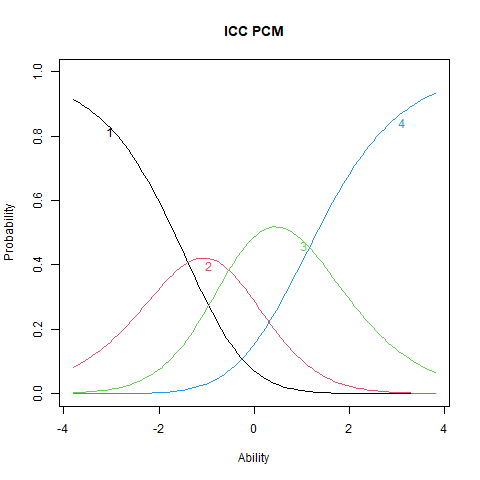

In [33]:
%%R
plot(stpcm, main = "ICC PCM", items = 1)

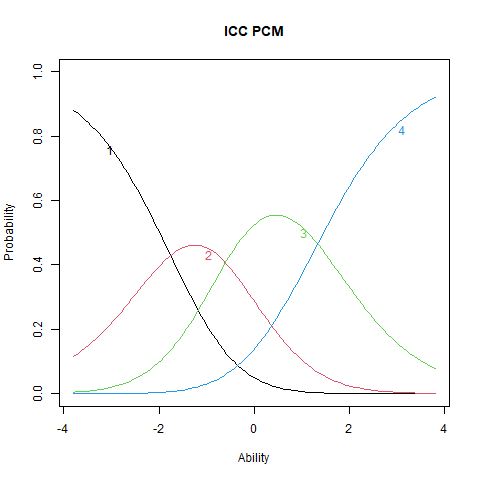

In [36]:
%%R
plot(stpcm, main = "ICC PCM", items = 2)

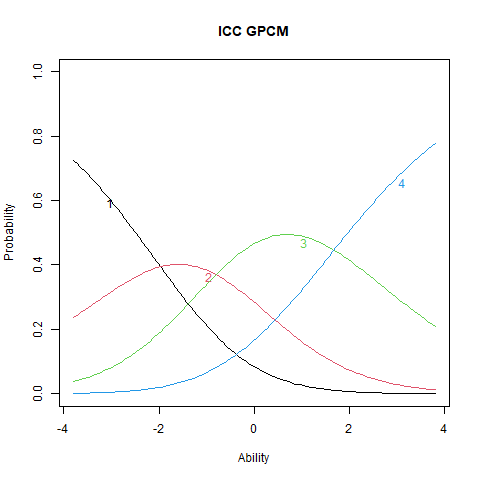

In [32]:
%%R
plot(stgpcm, main = "ICC GPCM", items = 1)

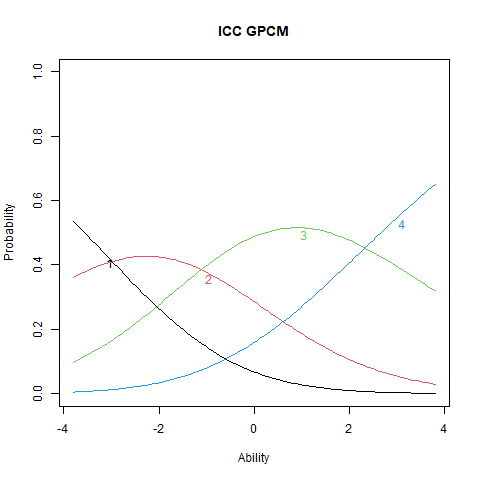

In [35]:
%%R
plot(stgpcm, main = "ICC GPCM", items = 2)

## Interpreting ICCs in PCM vs. GPCM

The ICC plots illustrate the structural differences between PCM and GPCM. The **upper panels** display ICCs for two items estimated under the **PCM**, where the **slopes are constant** both *within* and *across* items. Although the ICCs may appear visually similar, slight differences still emerge due to item-specific threshold locations. The **lower panels** show ICCs from the **GPCM** fit. Here, **slopes vary across items**, but remain constant within each item—this variation arises from the inclusion of **item-specific discrimination parameters** ($\alpha_i$).

## Interpretation

Items with higher $\alpha_i$ values exhibit **steeper ICCs**, indicating **greater sensitivity** to differences in the latent trait. These items are more effective at distinguishing between individuals at different trait levels. Conversely, items with lower $\alpha_i$ values produce **flatter ICCs**, reflecting weaker associations with the latent trait and reduced discriminatory power. Such items contribute less precise information about a person's position on the trait continuum.


### Test your understanding

In [39]:
from jupyterquiz import display_quiz
display_quiz("quiz/quiz_gpcm.json")


<IPython.core.display.Javascript object>